In [1]:
%autoreload
import numpy as np
import pandas as pd
import xarray as xr

from pathlib import Path

from vibes.settings import ConfigDict
from vibes.correlation import get_autocorrelation
from vibes.integrate import get_cumtrapz

import scipy.signal as sl
from scipy.integrate import trapz, cumtrapz
from scipy.optimize import curve_fit

README
===

Only track $x$ coordinate

In [2]:
# read info
file = Path("info.toml")

info = ConfigDict("info.cfg").info

# read reference
flux_df = pd.read_csv('flux.csv.bz2', index_col=info.index_col)
kappa_df = pd.read_csv('kappa.csv.bz2', index_col=info.index_col)

In [3]:
def get_corr(series, step=10, nmax=100000, window=True):
    """return correlation function as pd.Series"""
    J = series.iloc[:nmax:step]
    time = J.index
    
    Nt = len(J)
    
    corr = sl.correlate(J, J)[Nt - 1 :]
    
    # Normalize
    corr /= np.arange(Nt, 0, -1)
    if window:  # window
        corr *= sl.windows.hann(2 * Nt)[Nt:]
    
    return pd.Series(corr, index=time)

[Integration]  Compute autocorrelation function
[Integration]  .. time elapsed: 0.023s


2.538168066917508e-07

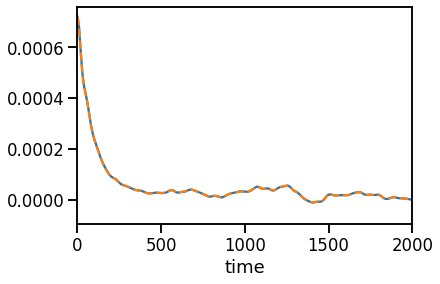

In [4]:
c1 = get_corr(flux_df.flux)
ax = c1.plot()

c2 = get_autocorrelation(flux_df.flux)
c2.plot(ax=ax, style='--', xlim=(0, 2000))

(c1 - c2).std()

In [5]:
info

{'index_col': 'time', 'vol': 9943.92, 'scale': 2.87289125255705, 'step': 10, 'tmax': 2000}

In [6]:
# compare to lammps verbatim

time = np.arange(2000, 100000, 2000)

step = info.step
tmax = info.tmax
scale = info.scale

k = []
for nmax in time:
    # corr = get_corr(flux_df.flux, step=step, nmax=nmax, window=False)[:]
    corr = get_autocorrelation(flux_df.flux.iloc[:nmax:step], window=False, verbose=False)
    k.append(trapz(corr[:tmax]) * scale * step )
    
df = pd.DataFrame({'kappa': k}, index=time)


# full corr
c = get_autocorrelation(flux_df.flux, verbose=False)  * scale
k2 = get_cumtrapz(c)

ax = df.kappa.plot()
kappa_df.kappa.plot(ax=ax, style='x', c='grey')
ax.axhline(k2.iloc[tmax], c='orange')

(df.kappa - kappa_df.kappa).std()
kappa_df.kappa.iloc[-1] - k2.iloc[tmax]

-0.0007236279933422463

In [7]:
xlim = (1, 50 * tmax)

ax = (c / c[0]).plot(xlim=xlim)
ax.set_xscale("log")
ax2 = ax.twinx()

ax.axvline(tmax)

ax2.plot(k2)

ax.set_ylabel('HCACF')
ax2.set_ylabel('$\kappa (t)$')

Text(0, 0.5, '$\\kappa (t)$')

/home/knoop/local/anaconda3/lib/python3.7/site-packages/matplotlib/mathtext.py:2542: SyntaxWarning: Exception creating Regex for oneOf, building MatchFirst
  p.subsuperop    <<= oneOf(["_", "^"])


In [8]:
def exp(x, y0, tau):
    return y0 * np.exp( - x / tau)


def F_avalanche(series, delta='auto', verbose=True):
    """Compute Avalanche Function (windowed noise/signal ratio)"""
    
    if delta == 'auto':
        # estimate correlation time
        
        exp = lambda x, y0, tau: y0 * np.exp( - x / tau)
        
        # where is jc drops below 1/e the first time
        idx = series[series < series.max() / np.e].index[0]
        x = series[:idx]
        (y0, tau), _ = curve_fit(exp, x.index, x)
    
        delta = len(series[series.index < tau])
        
        assert 0.5 < idx / tau < 2, (idx, tau)
        
        if verbose:
            print(f'Pre-est. correlation time (drop below 1/e): {idx:10.2f} fs')
            print(f'.. estimated correlation time:              {tau:10.2f} fs')
            print(f'-> choose delta of size: {delta:20d} data points')

    
    sigma = series.rolling(window=delta, min_periods=0).std()
    E = series.rolling(window=delta, min_periods=0).mean()
    
    F = (sigma / E).abs().dropna()

    return F

def t_avalanche(series, Fmax=1, verbose=True, **kwargs):
    """get avalanche time for series from F_avalanche"""
    F = F_avalanche(series, verbose=verbose, **kwargs)
    
    tmax = F[F > Fmax].index[0]
    
    if verbose:
        print(f'-> avalanche time with max. F of {Fmax:2d}: {tmax:17.2f} fs')
    
    return tmax

In [9]:
jc = get_autocorrelation(flux_df.flux)

# where is jc drops below 1/e the first time
idx = jc[jc < jc.max() / np.e].index[0]

j = jc[:1000]
j_fit = jc[:idx+1]
p, d = curve_fit(exp, j_fit.index, j_fit)

ax = j.plot()
plt.plot(np.asarray(j.index), np.asarray(exp(j.index, *p)))

ax.axvline(p[1])
ax.axvline(idx)
ax.axhline(0, color='k')

idx, p, d

[Integration]  Compute autocorrelation function
[Integration]  .. time elapsed: 0.020s


(90.0,
 array([7.30850324e-04, 8.76041104e+01]),
 array([[ 1.27912376e-11, -2.72541141e-06],
        [-2.72541141e-06,  9.39212946e-01]]))

[Integration]  Compute autocorrelation function
[Integration]  .. time elapsed: 0.019s
Pre-est. correlation time (drop below 1/e):      90.00 fs
.. estimated correlation time:                   87.57 fs
-> choose delta of size:                   88 data points
-> avalanche time with max. F of  1:           1387.00 fs


(0, 5)

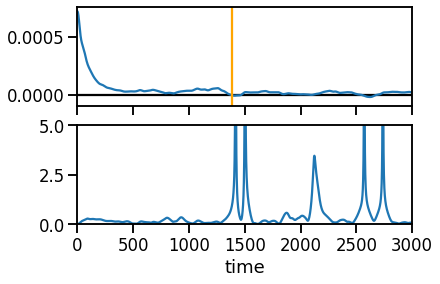

In [10]:
# full correlation function
jc = get_autocorrelation(flux_df.flux)
F = F_avalanche(jc, verbose=False)

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
ax1.axhline(0, color='k')

jc.plot(ax=ax1)
F.plot(ax=ax2)

ax1.axvline(t_avalanche(jc), color='orange')

ax2.set_xlim([0, 3000])
ax2.set_ylim([0, 5])

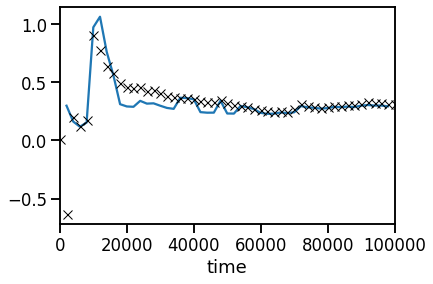

In [11]:
# using windowing and F avalanche

time = np.arange(2000, 100000, 2000)

step = 10

k = []
for nmax in time:
    corr = get_corr(flux_df.flux, step=step, nmax=nmax)
    tmax = t_avalanche(corr, verbose=False)
    k.append(trapz(corr[:tmax]) * scale * step )
    
df = pd.DataFrame({'kappa': k}, index=time)

ax = df.kappa.plot()
kappa_df.kappa.plot(ax=ax, style='x', c='k')

[Integration]  Compute autocorrelation function
[Integration]  .. time elapsed: 0.018s


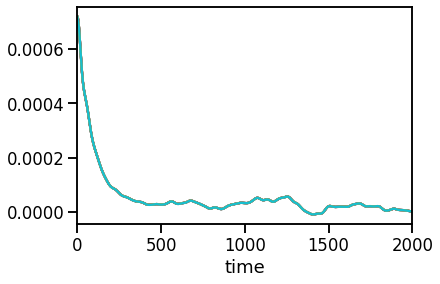

In [12]:
nmax = 2000

c = get_autocorrelation(flux_df.flux)[:nmax]

ax = c.plot()

for step in range(1, 10):
    get_corr(flux_df.flux, step=step)[:nmax].plot(ax=ax)